### Edgar Moises Hernandez-Gonzalez
#### 25/03/20-08/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = 68.06%
##### Kappa = 0.5741

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [9]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (8, 264) #ancho, alto
  fs = 250
  datos = np.zeros((288,264,8))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [12]:
print(x_train.shape)
print(x_test.shape)

(288, 264, 8)
(288, 264, 8)


In [13]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

65.53692251223107
55.06980719402351
0.001085261144493673
0.00041804610564340585


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 66.0
x_test /= 66.0

In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.99298376
0.83439106
1.644335e-05
6.334032e-06


In [16]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 264, 8, 1)
(288, 264, 8, 1)


In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
9/9 - 0s - loss: 2.4692 - accuracy: 0.6667
kappa:  0.5555555555555556
confusion matrix:
 [[55  8  7  2]
 [17 43 10  2]
 [ 6  0 39 27]
 [ 2  1 14 55]]


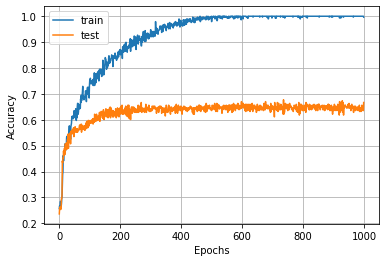

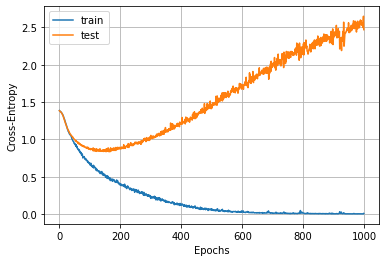

Iteration: 2
9/9 - 0s - loss: 2.4882 - accuracy: 0.6493
kappa:  0.5324074074074074
confusion matrix:
 [[54  9  8  1]
 [19 43  8  2]
 [ 4  0 41 27]
 [ 3  1 19 49]]


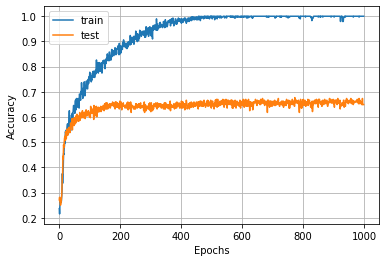

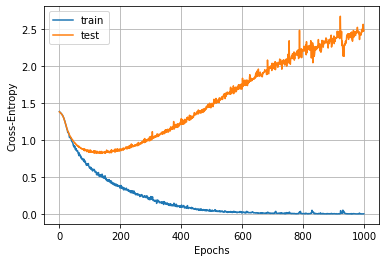

Iteration: 3
9/9 - 0s - loss: 2.5627 - accuracy: 0.6250
kappa:  0.5
confusion matrix:
 [[48 12 10  2]
 [20 42  8  2]
 [ 4  1 43 24]
 [ 2  1 22 47]]


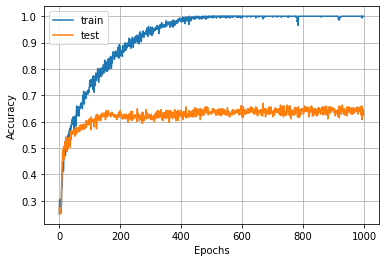

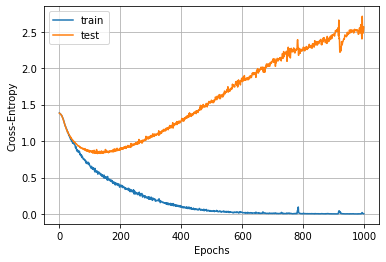

Iteration: 4
9/9 - 0s - loss: 2.3745 - accuracy: 0.6736
kappa:  0.5648148148148149
confusion matrix:
 [[49 11 10  2]
 [15 47  8  2]
 [ 4  0 45 23]
 [ 3  1 15 53]]


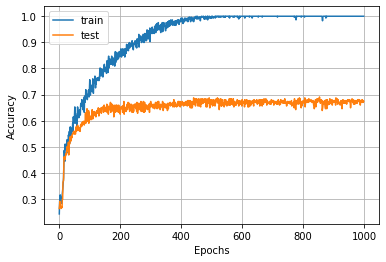

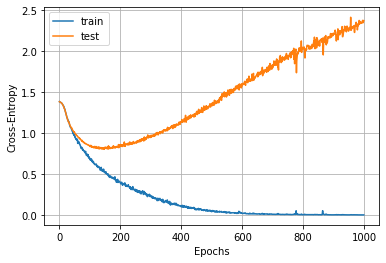

Iteration: 5
9/9 - 0s - loss: 2.3571 - accuracy: 0.6250
kappa:  0.5
confusion matrix:
 [[44 12 14  2]
 [17 43 10  2]
 [ 2  1 46 23]
 [ 4  1 20 47]]


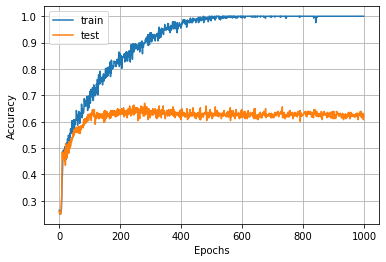

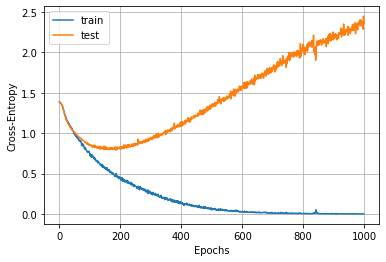


Resultados:
loss: [2.469207525253296, 2.4881858825683594, 2.5627195835113525, 2.3745131492614746, 2.357135534286499]
accuracy: [0.6666666865348816, 0.6493055820465088, 0.625, 0.6736111044883728, 0.625]
kappa: [0.5555555555555556, 0.5324074074074074, 0.5, 0.5648148148148149, 0.5]


In [21]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=1000, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [22]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 264, 8, 16)        160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 132, 4, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 132, 4, 16)        2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 66, 2, 16)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               270464    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

In [23]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6479
std: (+/- 0.0203)
Mean Kappa: 0.5306
std: (+/- 0.0271)
Max Accuracy: 0.6736
Max Kappa: 0.5648
